PPO Pendulum-v0 environment
- Continuous action space
- No Parameter sharing
- Normalized reward

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.fc1 = nn.Linear(3,512)
        self.fc2 = nn.Linear(3,512)
        self.fc_pi_mu = nn.Linear(512,1)
        self.fc_pi_sig = nn.Linear(512,1)
        self.fc_v = nn.Linear(512,1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0005)
    
    def forward(self, x):
        x_pi = F.relu6(self.fc1(x))
        policy_mu = 2*torch.tanh(self.fc_pi_mu(x_pi))
        policy_sig = F.softplus(self.fc_pi_sig(x_pi)) + 0.001 ## sigma > 0
        x_v = F.relu6(self.fc2(x))
        v = self.fc_v(x_v)
        return policy_mu, policy_sig, v
    
    def train(self, loss):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

In [3]:
env = gym.make('Pendulum-v0')
model = PPO()
GAMMA = 0.98
LAMBDA = 0.95
EPOCH = 3
EPS = 0.09
T = 20

In [4]:
def append_data(s_list, p_list, a_list, r_list, state, policy, reward, action):
    s_list.append(state)
    p_list.append(policy.unsqueeze(0))
    r_list.append(reward)
    a_list.append(action)
    
def make_GAE(delta):
    GAE_list = []
    temp_GAE = 0.0
    delta_list = delta.reshape(-1).detach().numpy()
    for d in delta_list[::-1]:
        temp_GAE *= GAMMA*LAMBDA
        temp_GAE += d
        GAE_list.append(temp_GAE)
    GAE_list.reverse()
    return torch.tensor(GAE_list, dtype=torch.float).reshape(-1,1)
    
def make_loss_and_training(s_list, p_list, a_list, r_list, done):
    s_tensor = torch.cat(s_list, dim=0)
    r = torch.tensor(r_list, dtype=torch.float).reshape(-1,1)
    old_pi = torch.cat(p_list, dim=0).detach()
    a = torch.tensor(a_list).reshape(-1,1)
    
    for K in range(EPOCH):
        cur_pi = torch.cat(model(s_tensor[:-1])[0:2], dim=1)
        values = model(s_tensor)[2]
        cur_value = values[:-1]
        next_value = values[1:]
        if done: next_value[-1] *= 0 ####### Very important!!! terminal state value must be zero!!!! #######
        td_error = r + GAMMA*next_value - cur_value
        td_target = r + GAMMA*next_value
        At = make_GAE(td_error)
        ratio = torch.exp(Normal(cur_pi[:,[0]], cur_pi[:,[1]]).log_prob(a) - Normal(old_pi[:,[0]], old_pi[:,[1]]).log_prob(a))
        loss_clip = torch.min(ratio*At, torch.clamp(ratio, 1-EPS, 1+EPS)*At)
        loss_vf = F.smooth_l1_loss(cur_value, td_target.detach())
        entropy = Normal(cur_pi[:,[0]], cur_pi[:,[1]]).entropy()
        total_loss = (-loss_clip + loss_vf).mean()
        model.train(total_loss)

In [5]:
reward_sum = 0.0
reward_list = []

for ep in range(20000):
    observation = env.reset()
    state = torch.tensor(observation, dtype=torch.float).unsqueeze(0)
    done = False
    while not done:
        s_list, r_list, a_list, p_list = [], [], [], []
        for t in range(T):
            policy_mu, policy_sig, _ = model(state)
            policy_mu, policy_sig = policy_mu[0], policy_sig[0]
            action = Normal(policy_mu, policy_sig).sample()
            observation, reward, done, _ = env.step([action.item()])
            
            reward_sum += reward
            append_data(s_list, p_list, a_list, r_list, state, torch.cat([policy_mu, policy_sig]), (reward+8.1)/8.1, action)
            
            state = torch.tensor(observation, dtype=torch.float).unsqueeze(0)
            if done:
                break
        s_list.append(state)
        make_loss_and_training(s_list, p_list, a_list, r_list, done)
        
    if ep % 100 == 99:
        print('Episode %d'%ep,', Reward mean : %f'%(reward_sum/100.0))
        reward_list.append(reward_sum/100.0)
        #plt.plot(reward_list)
        #plt.show()
        if reward_sum/100.0 > -300: break
        reward_sum = 0.0
        
env.close()

Episode 99 , Reward mean : -1393.876112
Episode 199 , Reward mean : -1210.031902
Episode 299 , Reward mean : -1113.845560
Episode 399 , Reward mean : -1012.259265
Episode 499 , Reward mean : -938.036311
Episode 599 , Reward mean : -799.513645
Episode 699 , Reward mean : -760.148739
Episode 799 , Reward mean : -711.962554
Episode 899 , Reward mean : -671.219698
Episode 999 , Reward mean : -912.062981
Episode 1099 , Reward mean : -1014.647644
Episode 1199 , Reward mean : -895.224456
Episode 1299 , Reward mean : -811.378232
Episode 1399 , Reward mean : -594.067769
Episode 1499 , Reward mean : -617.637487
Episode 1599 , Reward mean : -744.786903
Episode 1699 , Reward mean : -1052.802030
Episode 1799 , Reward mean : -1102.051171
Episode 1899 , Reward mean : -1047.530182
Episode 1999 , Reward mean : -902.777891
Episode 2099 , Reward mean : -686.389795
Episode 2199 , Reward mean : -717.399164
Episode 2299 , Reward mean : -668.150993
Episode 2399 , Reward mean : -748.262003
Episode 2499 , Rewa

Learning curve

mean reward every 100 episodes

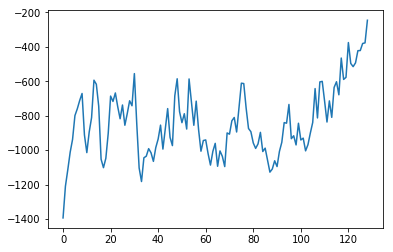

In [6]:
plt.plot(reward_list)
plt.show()

Test rendering

In [9]:
for ep in range(10):
    observation = env.reset()
    while True:
        time.sleep(0.05)
        env.render()

        state = torch.tensor(observation, dtype=torch.float).unsqueeze(0)
        p_mu, p_sig, _ = model(state)
        action = Normal(p_mu[0], p_sig[0]).sample()
        observation, reward, done, _ = env.step([action.item()])
        if done: break
env.close()

Reference

- https://github.com/seungeunrho/minimalRL
- https://github.com/MorvanZhou/pytorch-A3C